## <font color='darkblue'>대회 소개</font>


### VinBigData Chest X-ray Abnormalities Detection  





**Automatically localize and classify thoracic abnormalities from chest radiographs**  
https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/overview


---



## <font color="blue">패키지 불러오기</font>

In [27]:
import numpy as np
import pandas as pd 
import cv2

import torch
import torchvision

# 데이터 로더 관련
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from datetime import datetime
import time
import os
import sys
import warnings

from random import randint
import random
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

---

## <font color="blue">kaggle에서 EfficientDet을 사용하기 위한 준비 과정</font>

* VinBigData lib을 검색하여 현재 디렉토리에 추가해준다.(Add data)
* 아래 코드를 실행하여 wheel 설치를 진행하고, 경로를 추가해주면 `effdet` 패키지를 사용할 수 있다.

In [4]:
!pip install ../input/vbg-lib/timm-0.1.26-py3-none-any.whl
!tar xfz ../input/vbg-lib/pkgs.tgz
# for pytorch1.6
cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
!$cmd

Processing /kaggle/input/vbg-lib/timm-0.1.26-py3-none-any.whl


In [5]:
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")

In [8]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

---

## <font color="blue">데이터 경로 설정</font>

In [10]:
args = {
    'TRAIN_DATA' : '../input/vinbigdata-original-image-dataset/vinbigdata/train',
}

---

## <font color="blue">데이터 불러오기</font>

* Bounding Box가 검출이 되지 않은 이미지는 제외해보자.

In [11]:
train = pd.read_csv('/kaggle/input/vinbigdata-original-image-dataset/vinbigdata/train.csv')
train = train.loc[train['class_id']!=14]
train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353


---

## <font color="blue">이미지 확인하기</font>

* 한 이미지에서 여러 boundingbox가 겹쳐 보이는 이유는, `multiple radiologists`가 labeling을 했기 때문이다.

* Data Description의 설명을 확인하자.

    `Note that a key part of this competition is working with ground truth from multiple radiologists.`

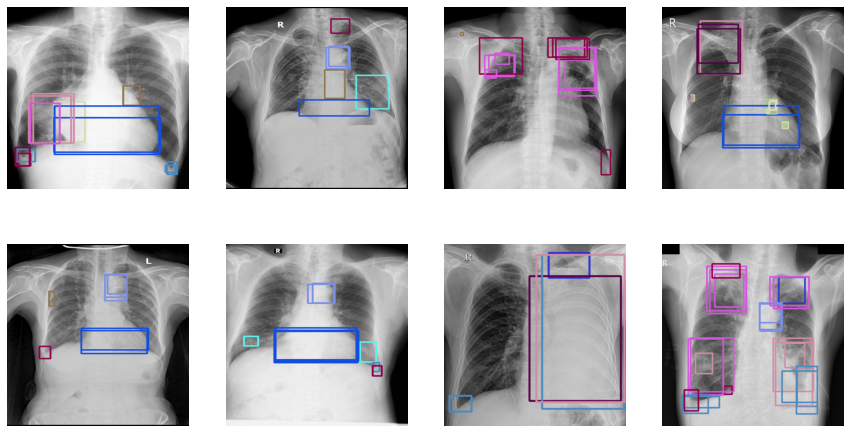

In [14]:
imgs = []
img_ids = train['image_id'].values
class_ids = train['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
scale = 5

fig , axes = plt.subplots(2,4)
fig.set_size_inches(15,8)

for index in range(8):
    img_id = random.choice(img_ids)
    img_path = f'{args["TRAIN_DATA"]}/{img_id}.jpg'
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    boxes = train.loc[train['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values/scale
    labels = train.loc[train['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 3)
        
    img = cv2.resize(img, (500,500))
    
    axes[index//4 , index%4].imshow(img)
    axes[index//4,  index%4].axis('off')

---

## <font color="blue">데이터 전처리</font>

### <font color="green">데이터 로더 만들기</font>

* 데이터 로더 만들 시 주의할 점은, 어떤 Detection 모델을 사용하느냐에 따라 `boxes` 좌표 순서가 바뀔 수 있다는 점이다.
* `EfficientDet` 모델은 `y_min`, `x_min`, `y_max`, `x_max` 순서로 좌표가 들어가므로 이에 맞춰서 전처리를 해주어야 한다.
* Kaggle에서 `dicom` 파일의 이미지들을 `jpg` 포맷으로 바꿔놓은 데이터가 올라와 있으므로, 이 데이터를 사용해보자.

In [15]:
class VinBigDataset(Dataset):
    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        self.marking = marking
        self.image_ids = image_ids
        self.transforms = transforms
        self.test = test
        
    def __len__(self):
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f"{args['TRAIN_DATA']}/{image_id}.jpg", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image / 255.0
        
        records = self.marking[self.marking['image_id']==image_id]
        boxes = records[['x_min','y_min','x_max','y_max']].values
        labels = records['class_id'].values
        
        return image, boxes, labels
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {'boxes':boxes, 'labels': torch.tensor(labels)}
        
        if self.transforms:
            sample = {'image' : image, 'bboxes' : boxes, 'labels' : labels}
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(sample['bboxes'])))).squeeze(1)
            
        target['boxes'][:,[0,1,2,3]] = target['boxes'][:, [1,0,3,2]]
        
        return image, target, image_id

### <font color="green">Train Valid 나누기</font>

* Train, Valid 데이터는 8:2로 나눠보자.
* 데이터 로더에 들어갈 형식에 맞게 이미지 id들을 나눠준다.

In [16]:
random_seed= 42

image_names = np.random.permutation(train['image_id'].unique())

val_len = int(len(image_names)*0.2)

images_train = image_names[:-val_len]
images_valid = image_names[-val_len:]
print(len(images_train), len(images_valid))

3516 878


### <font color="green">transforms 함수 만들기</font>

* 이미지들의 크기가 모두 다르기 때문에, `Resize` 함수로 전처리를 해준다.
* 데이터 로더는 나중에 정의할 것이기 때문에, 여기서는 `train_set`, `valid_set`만 정의해주자.

In [19]:
def get_train_transforms():
    return A.Compose([A.Resize(512,512),
                      A.Flip(0.5),
                      ToTensorV2()], 
                     bbox_params=A.BboxParams(format='pascal_voc', 
                                              label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([A.Resize(512,512),
                      ToTensorV2()], 
                     bbox_params=A.BboxParams(format='pascal_voc', 
                                              label_fields=['labels']))

In [20]:
train_set = VinBigDataset(train, images_train,transforms=get_train_transforms(), test=False)
valid_set = VinBigDataset(train, images_valid, transforms=get_valid_transforms(), test=True)

---

## <font color="blue">모델 훈련을 위한 함수 정의</font>

### <font color="green">Fitter 클래스 정의</font>

* 모델 학습 파이프라인을 설정해주자.

#### <font color='purple'>fit 함수</font>
* 전체 `Epoch` 동안의 학습 과정을 관리하는 함수이다.

#### <font color='purple'>train_one_epoch 함수</font>
* 하나의 `Epoch` 내의 모델 학습 과정을 관리하는 함수이다.

#### <font color='purple'>validation 함수</font>
* 하나의 `Epoch` 내의 valid 데이터 예측 및 평가 과정을 관리하는 함수이다.

#### <font color='purple'>save 함수</font>
* 모델 학습 과정에서, 모델의 파라미터 저장 등을 관리하는 함수이다.

#### <font color='purple'>load 함수</font>
* 저장된 모델 파라미터 등을 불러오는 함수이다.

#### <font color='purple'>logger 함수</font>
* 학습이 진행되는 동안의 log를 기록하는 함수이다.

---

* 참고 사이트
    * model.named_parameters() : https://comlini8-8.tistory.com/50
    * AdamW : https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html

In [38]:
class Fitter:
    def __init__(self, model, device, config):
        self.model = model
        self.device = device
        self.config = config
        self.epoch = 0
        self.base_dir = f"./{config.folder}"
        
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f"{self.base_dir}/log.txt"
        self.best_summary_loss = 10**5
        self.param_optimizer = list(self.model.named_parameters())
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr = config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f"device is {self.device}")

    def fit(self, train_loader, valid_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f"시간 : {timestamp}, Learning Rate : {lr}")
            
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}') # loss 평균   
            self.save(f"{self.base_dir}/last-checkpoint.bin")
            
            t = time.time()
            summary_loss = self.validation(valid_loader)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
            
                try:
                    os.remove(f)
                except:
                    pass
                
                f = f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin'

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)
            
            self.epoch+=1
                
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(f"Val Step : {step}/{len(val_loader)}, " + \
                          f"summary_loss : {summary_loss.avg:.5f}, " + \
                          f"time : {(time.time() - t):.5f}", end="\r"
                         )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [x['boxes'].to(self.device).float() for x in targets]
                labels = [x['labels'].to(self.device).float() for x in targets]
                
                loss, _, _ = self.model(images, boxes, labels)
                
                summary_loss.update(loss.detach().item(), batch_size)
        return summary_loss
                    
    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(f"Train Step : {step}/{len(train_loader)}, " + \
                          f"summary_loss : {summary_loss.avg:.5f}, " + \
                          f"time : {(time.time() - t):.5f}", end="\r"
                         )
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [x['boxes'].to(self.device).float() for x in targets]
            labels = [x['labels'].to(self.device).float() for x in targets]
            
            self.optimizer.zero_grad()
            loss, _, _ = self.model(images, boxes, labels)
            loss.backward()
            summary_loss.update(loss.detach().item(), batch_size)
            self.optimizer.step()
            
            if self.config.step_scheduler:
                self.scheduler.step()
        
        return summary_loss            
        
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict' : self.model.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict(),
            'scheduler_state_dict' : self.scheduler.state_dict(),
            'best_summary_loss' : self.best_summary_loss,
            'epoch' : self.epoch
        }, path)
        
    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

### <font color="green">AverageMeter 클래스 정의</font>

* Loss 계산을 위한 클래스를 정의한다.

In [39]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### <font color="green">TrainGlobalConfig 클래스 정의(하이퍼 파라미터 설정)</font>

* Fitter 클래스에서 사용될 하이퍼파라미터를 설정한다.

In [40]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 20
    lr = 0.0002
    folder = 'effdet5-models'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=5,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

### <font color="green">데이터로더 정의 및 학습 함수(Fit) 정의</font>

* `DataLoader`의 파라미터별 용도 참고 : https://subinium.github.io/pytorch-dataloader/
    * `shuffle` : 데이터를 섞어서 불러오는 옵션
    * `sampler` : shuffle과 유사한 옵션이나,index를 조정하는 옵션. 이 옵션을 사용하려면 `shuffle`옵션은 `False`(기본값)이어야 한다.
        * `RandomSampler` : 랜덤으로 불러온다. Replacement 여부 선택 가능, 개수 선택 가능
        * `SequentialSampler` : 항상 같은 순서로 불러온다.
    * `pin_memory` : 메모리 소모를 줄이는 옵션. Tensor를 CUDA 고정 메모리에 올린다.
    * `drop_last` : Batch의 길이가 다른 경우에 따라 loss를 구하기 어려운 경우가 생기고, batch의 크기에 따른 의존도 높은 함수를 사용할 때 걱정이 되는 경우 `True` 옵션을 주어 마지막 batch를 사용하지 않을 수 있다.
    * `collate_fn` : map-style 데이터셋에서 sample list를 batch 단위로 바꾸기 위해 필요한 옵션. Zero-padding이나 Variable Size 데이터 등 데이터 사이즈를 맞추기 위해 많이 사용한다.

In [41]:
def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_set),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        valid_set, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_set),
        pin_memory=False,
        collate_fn=collate_fn,
    )
    
    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

def collate_fn(batch):
    return tuple(zip(*batch))

### <font color="green">모델 정의</font>

* 모델은 `EfficientDet`을 사용해본다.
* pretrained를 True로 설정하고, 모델의 config.num_classes를 사용 목적에 맞게 꼭 바꿔주자. 그렇지 않으면 모델 학습시 input 사이즈 에러가 발생한다.

In [42]:
def get_net():
    config = get_efficientdet_config("tf_efficientdet_d0")
    net = EfficientDet(config, pretrained_backbone=True)
    config.image_size = 512
    config.num_classes = 14
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    return DetBenchTrain(net, config)

---

## <font color="blue">모델 훈련</font>

* 시드를 고정시킨 후, 학습을 진행한다.

In [ ]:
random_seed= 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

net = get_net()
run_training()

device is cuda:0
시간 : 2021-04-17T06:39:02.714171, Learning Rate : 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 248.13443, time: 522.19967
[RESULT]: Val. Epoch: 0, summary_loss: 7.92773, time: 104.95752
시간 : 2021-04-17T06:49:30.211356, Learning Rate : 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 3.93020, time: 518.21235
[RESULT]: Val. Epoch: 1, summary_loss: 2.32165, time: 102.05856
시간 : 2021-04-17T06:59:50.871942, Learning Rate : 0.0002


---

## <font color="blue">결론</font>

* EfficientDet b0를 사용한 베이스라인 코드이다.
* 여러 방사선 전문의들이 레이블링하였기 때문에 이러한 `overlapping boxes`에 대한 전처리가 필요할 것으로 보인다.
* 또한, CutMix 기법, Weighted Boxes Fusion 등을 적용해볼 수 있다. 모델 역시 YOLOv5 등을 사용해볼 수 있다.


* 코드 참고 : https://www.kaggle.com/morizin/14-class-efficientdet-detection-train

### <font color="green">Weighted Boxes Fusion Example</font>

* 겹치는 박스(동일 레이블)를 처리할 수 있다.

* Weighted Boxes Fusion 내용 : https://towardsdatascience.com/wbf-optimizing-object-detection-fusing-filtering-predicted-boxes-7dc5c02ca6d3